In [1]:
# general purpose modules for handling data
import numpy as np
from numpy import array
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

# for loading telo data column containing individual
# telomere length values
from ast import literal_eval

# data visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# plot type I really like
from ptitprince import PtitPrince as pt

# custom module for handling telomere length data
import telomere_methods_astros as telo_ma

# statistics
import scipy.stats as stats
import scikit_posthocs as sp

In [2]:
# setting all graphs to have darkgrid style w/ black edges for axes elements

sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

### Reading in all astronaut telomere length data to a dataframe

In [4]:
astro_df = pd.read_csv('../excel data/All_astronauts_telomere_length_dataframe.csv')
astro_df['telo data'] = astro_df['telo data'].apply(lambda row: np.array(literal_eval(row)))
astro_df['astro id'] = astro_df['astro id'].astype('str')

In [5]:
astro_df.head(4)

,astro number,astro id,timepoint,flight status,telo data,telo means,Q1,Q2-3,Q4
0,1,5163,L-270,Pre-Flight,"[46.9762779819579, 78.38289341797528, 105.1119...",87.672120,telos preF Q1 <0.25,telos preF Q2-3 >0.25 & <0.75,telos preF Q4 >0.75
1,1,5163,L-180,Pre-Flight,"[102.38890745071835, 107.3170731707317, 61.944...",101.077756,telos preF Q1 <0.25,telos preF Q2-3 >0.25 & <0.75,telos preF Q4 >0.75
2,1,5163,L-60,Pre-Flight,"[92.4323421316405, 144.537253591714, 135.59973...",128.599235,telos preF Q1 <0.25,telos preF Q2-3 >0.25 & <0.75,telos preF Q4 >0.75
3,1,5163,FD90,Mid-Flight,"[89.22485800200468, 116.6388239224858, 116.221...",101.183129,telos preF Q1 <0.25,telos preF Q2-3 >0.25 & <0.75,telos preF Q4 >0.75


First.. let's see how mean telomere length changes w/ respect to spaceflight when all 11 astronauts are averaged together for pre-, mid-, & post-flight timepoints

Text(0, 0.5, 'Mean Telomere Length')

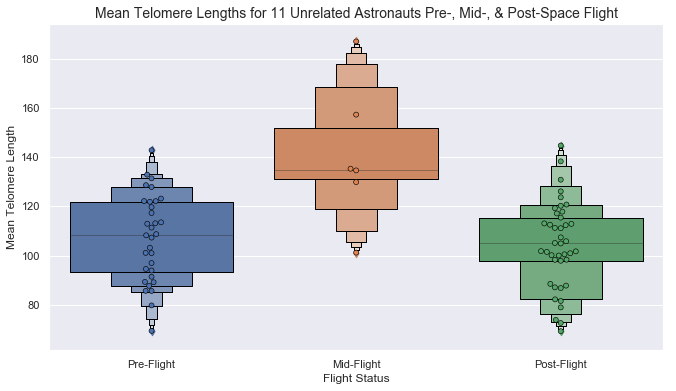

In [605]:
fig = plt.figure(figsize=(11,6))
ax = sns.boxenplot(x='flight status', y='telo means', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], data=astro_df)
ax = sns.swarmplot(x='flight status', y='telo means', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], data=astro_df,
                  linewidth=.6, edgecolor="black", dodge=True)

ax.set_title('Mean Telomere Lengths for 11 Unrelated Astronauts Pre-, Mid-, & Post-Space Flight', fontsize=14)
ax.set_xlabel('Flight Status', fontsize=12)
ax.set_ylabel('Mean Telomere Length', fontsize=12)

In [613]:
# one-way anova between mean telomere lengths per timepoint
pre_flight = astro_df[astro_df['flight status'] == 'Pre-Flight']['telo means']
mid_flight = astro_df[astro_df['flight status'] == 'Mid-Flight']['telo means']
post_flight = astro_df[astro_df['flight status'] == 'Post-Flight']['telo means']
                      
print(stats.f_oneway(pre_flight, mid_flight, post_flight))
sp.posthoc_ttest(astro_df, val_col='telo means', group_col='flight status', p_adjust='holm')

# I need to grab cell means for statistical tests; would be better for graphing as well?

F_onewayResult(statistic=10.31663691107309, pvalue=0.00010866812307219371)


,Pre-Flight,Mid-Flight,Post-Flight
Pre-Flight,-1.000000,0.000915,0.483015
Mid-Flight,0.000915,-1.000000,0.000202
Post-Flight,0.483015,0.000202,-1.000000


Mean telomere length increases as a function of spaceflight. Furthermore, mean telomere length for astronauts overall appears to be slightly shorter after spaceflight.. Let's see what telomere length looks like for just our astronauts w/ inflight data

In [608]:
only_mid_astros_df = astro_df[(astro_df['astro id'] == '5163') |
                              (astro_df['astro id'] == '1536') |
                              (astro_df['astro id'] == '2171')].copy()
only_mid_astros_df.shape

(24, 9)

Text(0.5, 1.0, 'Mean Telomere Lengths for 3 Unrelated Astronauts: Pre-, Mid-, Post-Flight')

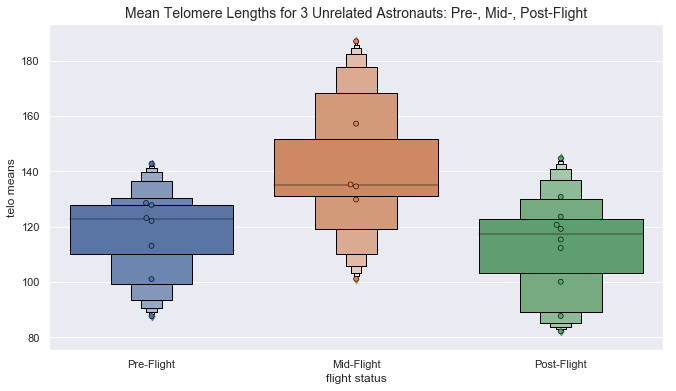

In [186]:
fig = plt.figure(figsize=(11,6))
ax = sns.boxenplot(x='flight status', y='telo means', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], data=only_mid_astros_df)
ax = sns.swarmplot(x='flight status', y='telo means', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], data=only_mid_astros_df,
                  linewidth=0.6, edgecolor='black')

ax.set_title('Mean Telomere Lengths for 3 Unrelated Astronauts: Pre-, Mid-, Post-Flight', fontsize=14)

In [612]:
# one-way anova between mean telomere lengths per timepoint

om_pre_flight = only_mid_astros_df[only_mid_astros_df['flight status'] == 'Pre-Flight']['telo means']
om_mid_flight = only_mid_astros_df[only_mid_astros_df['flight status'] == 'Mid-Flight']['telo means']
om_post_flight = only_mid_astros_df[only_mid_astros_df['flight status'] == 'Post-Flight']['telo means']
                      
# print(stats.f_oneway(om_pre_flight, om_mid_flight, om_post_flight))
# sp.posthoc_ttest(only_mid_astros_df, val_col='telo means', group_col='flight status', p_adjust='holm')

Ttest_indResult(statistic=-1.8291694183386562, pvalue=0.09231870227398672)

These 3 astronauts are our only individuals w/ inflight data, so the mid-flight mean telomere length has remained the same. The pre-/post-flight data has the same relationship compared to the data for all 11 astronauts: post-flight mean telomere length is *slightly* shorter.

Now.. our inflight astronauts had blood samples collected at different flight days. Let's first parse out the mean telomere length data per astronaut.

Text(0.5, 1.0, 'Mean Telomere Lengths per Astronaut for 3 Unrelated Astronauts: Pre-, Mid-, Post-Flight')

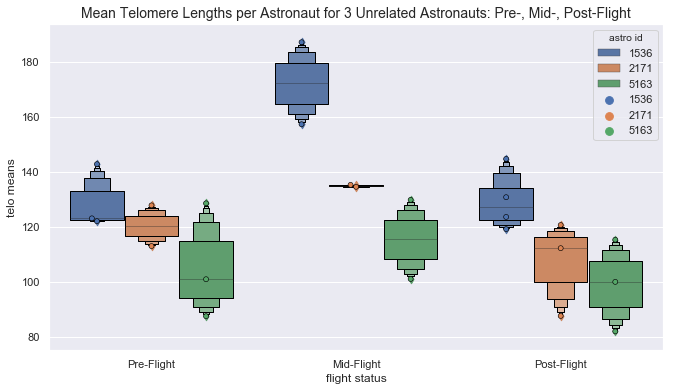

In [561]:
fig = plt.figure(figsize=(11,6))
ax = sns.boxenplot(x='flight status', y='telo means', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], hue='astro id', data=only_mid_astros_df, dodge=True)
ax = sns.swarmplot(x='flight status', y='telo means', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], hue='astro id', data=only_mid_astros_df,
                  linewidth=0.6, edgecolor='black', dodge=True)

ax.set_title('Mean Telomere Lengths per Astronaut for 3 Unrelated Astronauts: Pre-, Mid-, Post-Flight', fontsize=14)

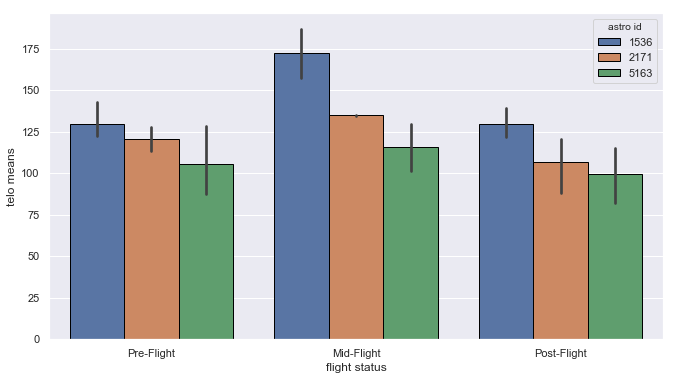

In [208]:
fig = plt.figure(figsize=(11,6))
ax = sns.barplot(x='flight status', y='telo means', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], hue='astro id', data=only_mid_astros_df, dodge=True)

Even when considered separately, for each astronaut the average of mean telomere length for their samples taken midflight was always longer than the average of samples pre-flight. As well, the average of mean telomere length for samples post-flight were slightly shorter. Interestingly, dso2171 looks to have similar mean telomere length for both blood draws.

Now we must consider if mean telomere length increases as a function of *duration in spaceflight*. We can do so b.c astros 1536&5163 samples were collected at FD90 & 140, while astro 2171 samples were collected at FD45 & 260. Let's first parse out the two mid-flight timepoints, then examine mid 1 & mid 2 for each astronaut

In [562]:
only_mid_astros_df['flight status mid split'] = only_mid_astros_df.loc[:, 'timepoint'].apply(lambda row: telo_ma.mid_split(row))

Text(0.5, 1.0, 'Mean Telomere Lengths for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight')

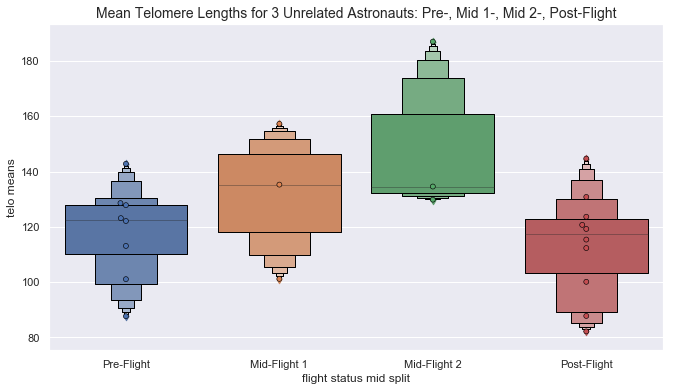

In [563]:
fig = plt.figure(figsize=(11,6))
ax = sns.boxenplot(x='flight status mid split', y='telo means', order=['Pre-Flight', 'Mid-Flight 1', 'Mid-Flight 2', 'Post-Flight'], data=only_mid_astros_df)
ax = sns.swarmplot(x='flight status mid split', y='telo means', order=['Pre-Flight', 'Mid-Flight 1', 'Mid-Flight 2', 'Post-Flight'], data=only_mid_astros_df,
                  linewidth=0.6, edgecolor='black')

ax.set_title('Mean Telomere Lengths for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight', fontsize=14)

The average of mean telomere lengths for mid-flight 2 is certainly higher than for mid-flight 1. There may be some relationship between telomere lengthening and spaceflight duration. However, telomere length does appear to have a biological upper bounds for species, though numerically undefined, thus it's unlikely that telomere length would increase indefinitely via spaceflight. Let's see how the data looks per astronaut.

Text(0.5, 1.0, 'Mean Telomere Lengths per Astronaut for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight')

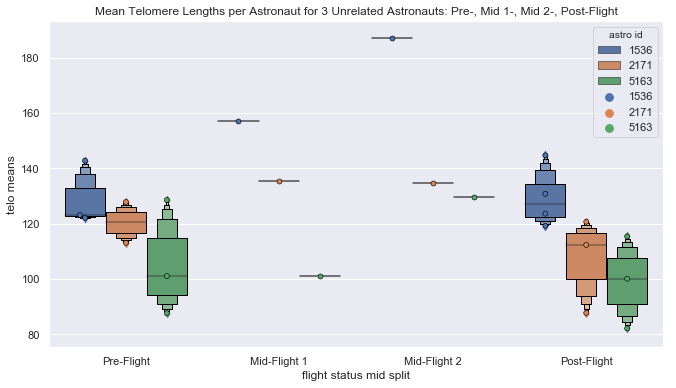

In [196]:
fig = plt.figure(figsize=(11,6))
ax = sns.boxenplot(x='flight status mid split', y='telo means', order=['Pre-Flight', 'Mid-Flight 1', 'Mid-Flight 2', 'Post-Flight'], 
                   hue='astro id', data=only_mid_astros_df, dodge=True)
ax = sns.swarmplot(x='flight status mid split', y='telo means', order=['Pre-Flight', 'Mid-Flight 1', 'Mid-Flight 2', 'Post-Flight'], 
                   hue='astro id', data=only_mid_astros_df,
                  linewidth=0.6, edgecolor='black', dodge=True)

ax.set_title('Mean Telomere Lengths per Astronaut for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight')

Astros 1536 & 5163 blood draws occured at FD90 & FD140, and both experienced an increase in mean telomere length at mid-flight 1 relative to pre-flight, and experienced an additional increase over mid-flight 1 at mid0flight 2.

Astro 2171 had blood draws at FD45 & FD260, and while mid-flight 1 had increased mean telomere length relative to pre-flight, mid-flight 2 was not. Rather, mid-flight 2 was numerically close to mid-flight 1. Altogether, mean telomere length does not appear to increase indefinitely with spaceflight. Our limited # of datapoints suggest that while mean telomere length increases mid-flight, it does not increase indefinitely.

Let's look at individual telomere lengths.

In [14]:
exploded_telos_astro_df = pd.read_csv('../excel data/exploded_telos_astros_df.csv')
exploded_telos_astro_df['astro id'] = exploded_telos_astro_df['astro id'].astype('str')

exploded_telos_astro_df.head(4)

,astro number,astro id,timepoint,flight status,telo means,telo data exploded
0,1,5163,L-270,Pre-Flight,87.672120,46.976278
1,1,5163,L-180,Pre-Flight,101.077756,102.388907
2,1,5163,L-60,Pre-Flight,128.599235,92.432342
3,1,5163,FD90,Mid-Flight,101.183129,89.224858


In [15]:
exploded_telos_only_mid_astros_df = exploded_telos_astro_df[(exploded_telos_astro_df['astro id'] == '5163') |
                              (exploded_telos_astro_df['astro id'] == '1536') |
                              (exploded_telos_astro_df['astro id'] == '2171')].copy()

exploded_telos_only_mid_astros_df.shape

(132480, 6)

In [16]:
exploded_telos_only_mid_astros_df['flight status mid split'] = exploded_telos_only_mid_astros_df['timepoint'].apply(lambda row: telo_ma.mid_split(row))

In [17]:
# fig = plt.figure(figsize=(12,6))
# ax = sns.boxenplot(x='flight status mid split', y='telo data exploded', order=['Pre-Flight', 'Mid-Flight 1', 'Mid-Flight 2', 'Post-Flight'], 
#                    data=exploded_telos_only_mid_astros_df,)

# ax.set_title('Individual Telomere Length Distributions for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight')

In [18]:
# fig = plt.figure(figsize=(12, 6))
# ax = sns.boxenplot(x='flight status mid split', y='telo data exploded', order=['Pre-Flight', 'Mid-Flight 1', 'Mid-Flight 2', 'Post-Flight'], hue='astro id',
#                    data=exploded_telos_only_mid_astros_df, dodge=True)

# ax.set_title('Individual Telomere Length Distributions per Astronaut for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight')

We've seen that mean telomere length increases during spaceflight. Now let us define short&long telomeres and visualize individual telomere length distributions per astronaut for timepoints most distal to spaceflight. 

To define short & long telomeres, we'll first find the earliest pre-flight samples for each astronaut. Then, in the individual telomere length distribution for that sample, we'll find the quartile boundary values for the bottom 25% of telos (short telos), middle 50%, and top 25% (long telos). The short, medium, and long telomeres will be colored yellow, blue, and pink respectively.

Once the quartile boundary values are established by the earliest pre-flight timepoint, the quartile boundary values will be used to color both midflight samples and the latest post-flight sample. In doing so, we can visualize and quantify the shifts of short/mid/long telomeres for each sample relative to the earliest timepoint. Now we have a means to discuss these classes of telomeres.

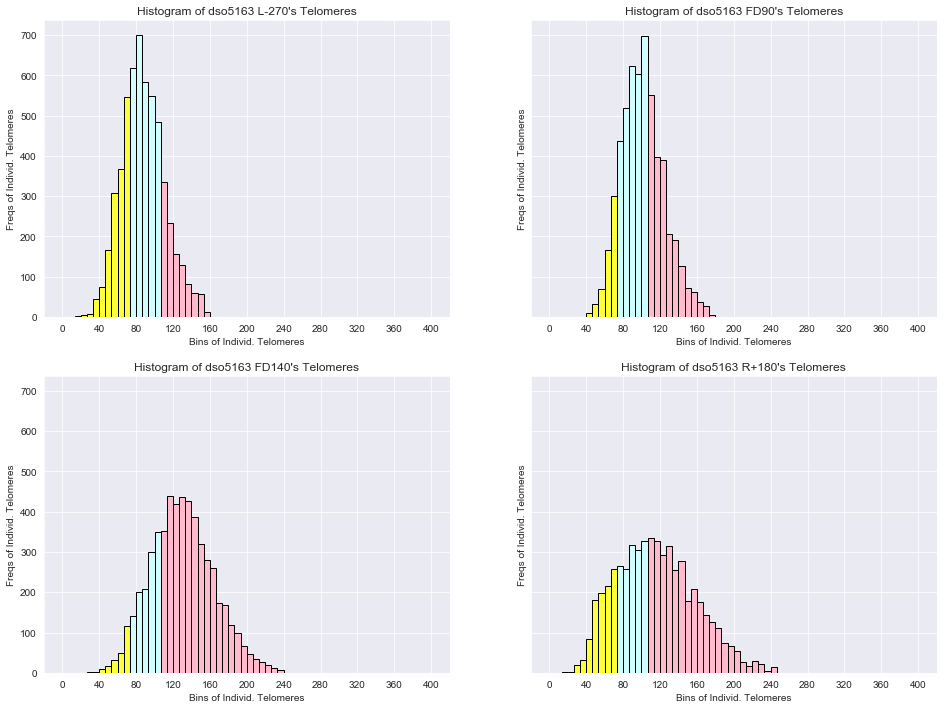

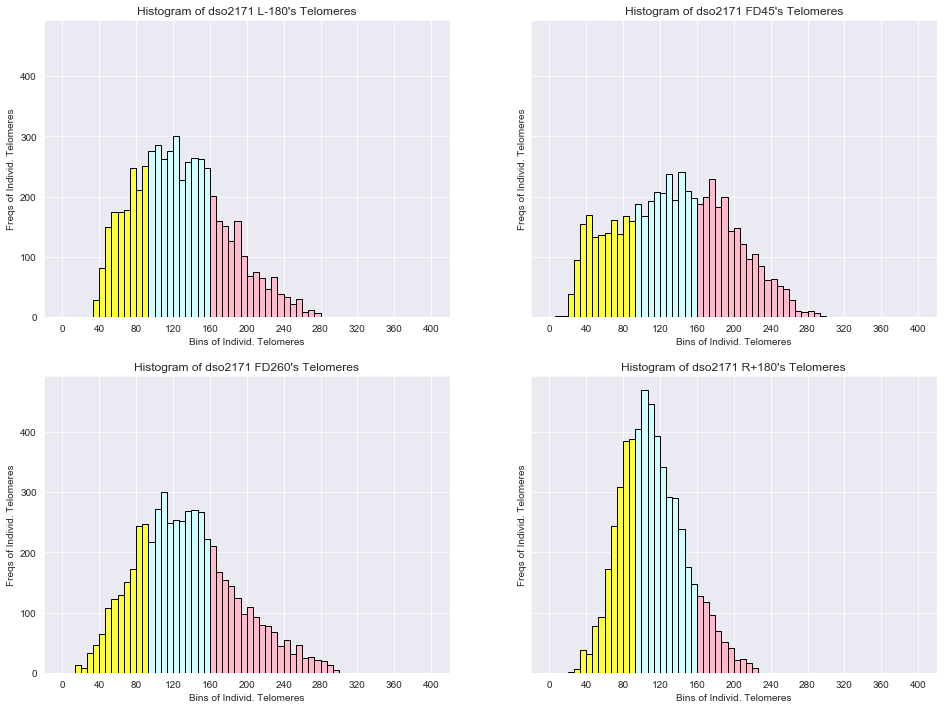

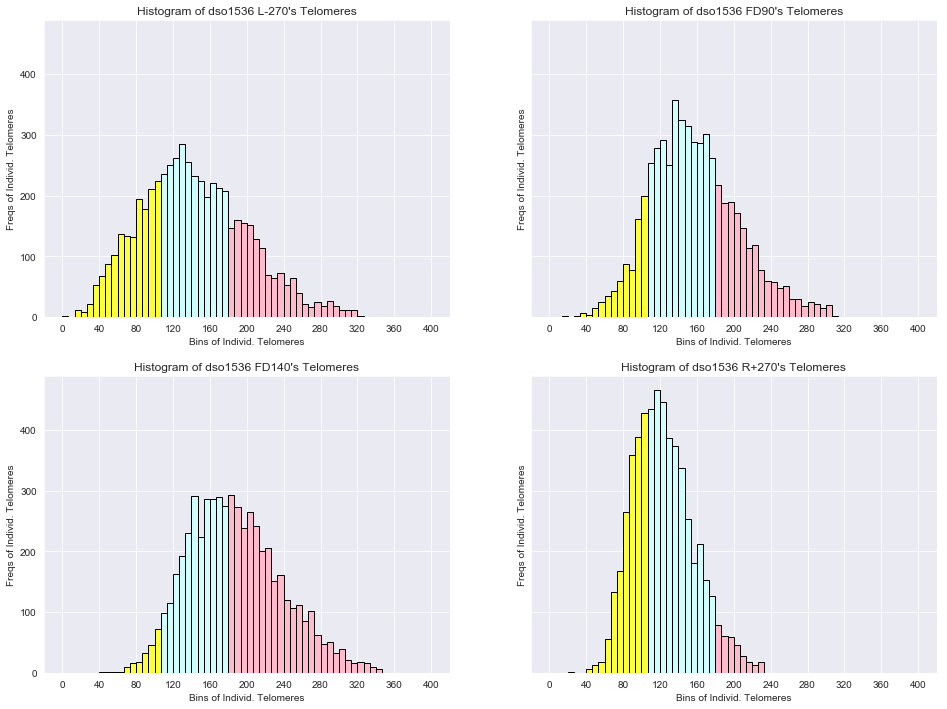

In [19]:
exploded_telos_only_mid_astros_df['astro id'] = exploded_telos_only_mid_astros_df['astro id'].astype('str')
telo_ma.make_histograms_colored_by_quartile_for_astronauts(exploded_telos_only_mid_astros_df)

Intriguingly, we see a *decrease* in short telos and an *increase* in long telos inflight. Furthermore, 2/3 astronauts experienced a remarkable increase in short telomeres post-flight. Now, let us quantify and visualize the #s of short/medium/long telomeres for the complete timecourse for these 3 unrelated astronauts.

In [379]:
melted_quartiles_astro_df = pd.read_csv('../excel data/melted_quartiles_astro_df.csv')

In [569]:
melted_quartiles_astro_df['astro id'] = melted_quartiles_astro_df['astro id'].astype('str')
melted_quartiles_astro_df.head(4)

,astro number,astro id,timepoint,flight status,telo data,telo means,relative Q,Q freq counts
0,1,5163,L-270,Pre-Flight,"[46.9762779819579, 78.38289341797528, 105.1119...",87.672120,Q1,1384
1,1,5163,L-180,Pre-Flight,"[102.38890745071835, 107.3170731707317, 61.944...",101.077756,Q1,848
2,1,5163,L-60,Pre-Flight,"[92.4323421316405, 144.537253591714, 135.59973...",128.599235,Q1,259
3,1,5163,FD90,Mid-Flight,"[89.22485800200468, 116.6388239224858, 116.221...",101.183129,Q1,472


In [570]:
mid_only_melted_quartiles_astro_df = melted_quartiles_astro_df[(melted_quartiles_astro_df['astro id'] == '5163') |
                              (melted_quartiles_astro_df['astro id'] == '1536') |
                              (melted_quartiles_astro_df['astro id'] == '2171')].copy()

distal_mid_only_melted_quartiles_astro_df = mid_only_melted_quartiles_astro_df
distal_mid_only_melted_quartiles_astro_df = mid_only_melted_quartiles_astro_df[(mid_only_melted_quartiles_astro_df['timepoint'] != 'L-60') &
                                                                               (mid_only_melted_quartiles_astro_df['timepoint'] != 'R+60') &
                                                                               (mid_only_melted_quartiles_astro_df['timepoint'] != 'R+7') & 
                                                                               (mid_only_melted_quartiles_astro_df['timepoint'] != 'R+5')].copy()

distal_mid_only_melted_quartiles_astro_df.head(5)

,astro number,astro id,timepoint,flight status,telo data,telo means,relative Q,Q freq counts
0,1,5163,L-270,Pre-Flight,"[46.9762779819579, 78.38289341797528, 105.1119...",87.672120,Q1,1384
1,1,5163,L-180,Pre-Flight,"[102.38890745071835, 107.3170731707317, 61.944...",101.077756,Q1,848
3,1,5163,FD90,Mid-Flight,"[89.22485800200468, 116.6388239224858, 116.221...",101.183129,Q1,472
4,1,5163,FD140,Mid-Flight,"[161.89442031406617, 152.82325425993986, 223.3...",129.851970,Q1,203
7,1,5163,R+180,Post-Flight,"[163.46475108586702, 157.11660541262947, 75.76...",115.403190,Q1,936


Text(0, 0.5, 'Individual Telos Freqs Within first time point Quartiles')

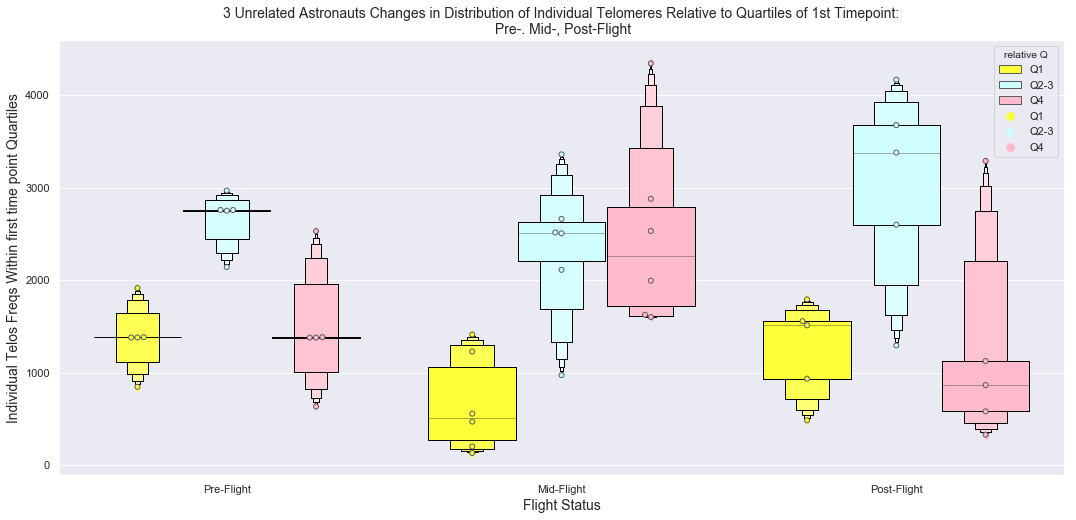

In [571]:
fig = plt.figure(figsize=(18,8))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

ax = sns.boxenplot(x='flight status', y='Q freq counts', hue='relative Q', data=distal_mid_only_melted_quartiles_astro_df, palette=palette,
             linewidth=2, saturation=5, color="black")
ax = sns.swarmplot(x='flight status', y='Q freq counts', hue='relative Q', data=distal_mid_only_melted_quartiles_astro_df, palette=palette,
             linewidth=1, color="black", dodge=True)

ax=fig.gca()
ax.set_title('3 Unrelated Astronauts Changes in Distribution of Individual Telomeres Relative to Quartiles of 1st Timepoint:\n Pre-. Mid-, Post-Flight', fontsize=14)
ax.set_xlabel('Flight Status', fontsize=14)
ax.set_ylabel('Individual Telos Freqs Within first time point Quartiles', fontsize=14)

In [572]:
distal_mid_only_melted_quartiles_astro_df['flight status mid split'] = (distal_mid_only_melted_quartiles_astro_df['timepoint']
                                                                                .apply(lambda row: telo_ma.mid_split(row)))


Text(0, 0.5, 'Individual Telos Freqs Within first time point Quartiles')

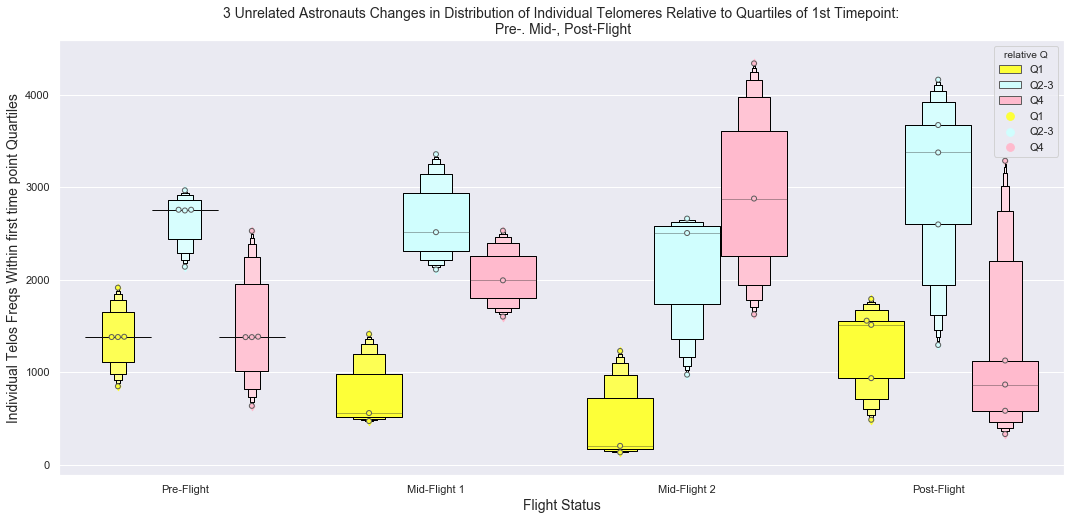

In [573]:
fig = plt.figure(figsize=(18,8))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

ax = sns.boxenplot(x='flight status mid split', y='Q freq counts', hue='relative Q', data=distal_mid_only_melted_quartiles_astro_df, palette=palette,
             linewidth=2, saturation=5, color="black")
ax = sns.swarmplot(x='flight status mid split', y='Q freq counts', hue='relative Q', data=distal_mid_only_melted_quartiles_astro_df, palette=palette,
             linewidth=1, color="black", dodge=True)

ax=fig.gca()
ax.set_title('3 Unrelated Astronauts Changes in Distribution of Individual Telomeres Relative to Quartiles of 1st Timepoint:\n Pre-. Mid-, Post-Flight', fontsize=14)
ax.set_xlabel('Flight Status', fontsize=14)
ax.set_ylabel('Individual Telos Freqs Within first time point Quartiles', fontsize=14)

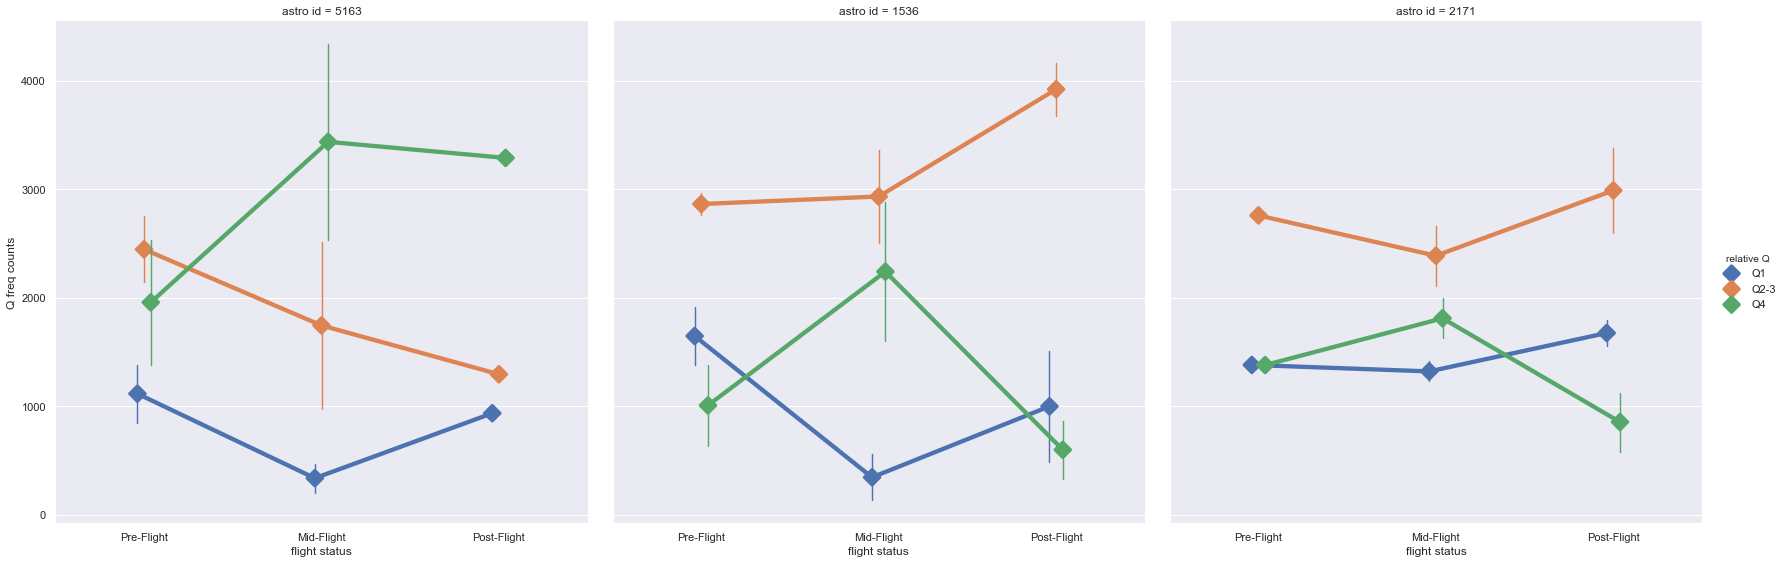

In [575]:
import matplotlib.patheffects as mpe

sns.set_style(style="darkgrid",rc={'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

# outline=mpe.withStroke(linewidth=20, foreground='black')
# pe1 = [mpe.Stroke(linewidth=8, foreground='black'),
#        mpe.Stroke(foreground='white',alpha=1),
#        mpe.Normal()]

sns.catplot(x='flight status', y='Q freq counts', hue='relative Q', col='astro id', col_order=['5163', '1536', '2171'], height=8, aspect=1,
           data=distal_mid_only_melted_quartiles_astro_df, kind='point', dodge=True,
            **{'markers': ['D', 'D', 'D'], 'scale': 3,})

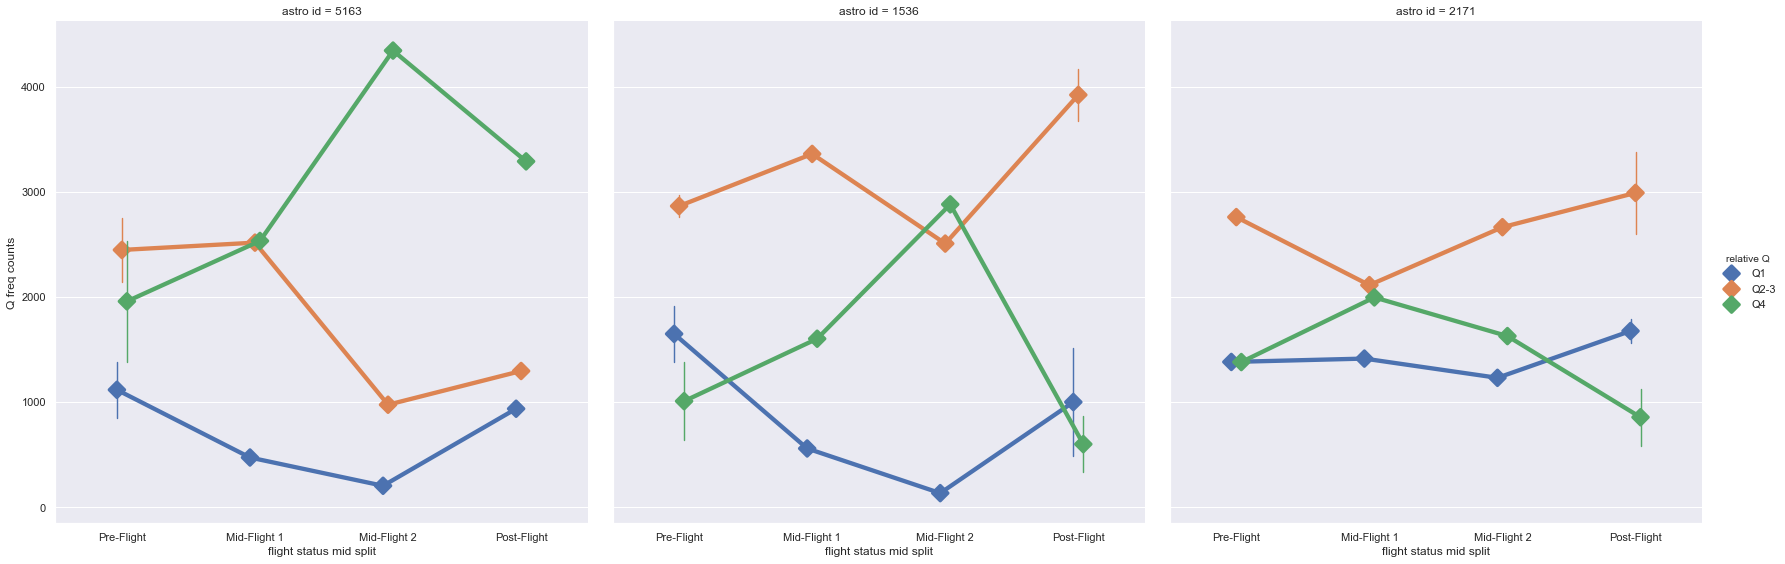

In [579]:
sns.set_style(style="darkgrid",rc={'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

sns.catplot(x='flight status mid split', y='Q freq counts', hue='relative Q', col='astro id', col_order=['5163', '1536', '2171'], height=8, aspect=1,
           data=distal_mid_only_melted_quartiles_astro_df, kind='point', dodge=True,
            **{'markers': ['D', 'D', 'D'], 'scale': 3,})

In [580]:
distal_melted_quartiles_astro_df = melted_quartiles_astro_df[(melted_quartiles_astro_df['timepoint'] != 'L-60') &
                                                             (melted_quartiles_astro_df['timepoint'] != 'R+5') &
                                                             (melted_quartiles_astro_df['timepoint'] != 'R+5') &
                                                             (melted_quartiles_astro_df['timepoint'] != 'R+7') &
                                                             (melted_quartiles_astro_df['timepoint'] !='R+60')].copy()

Text(0, 0.5, 'Individual Telos Freqs Within first time point Quartiles')

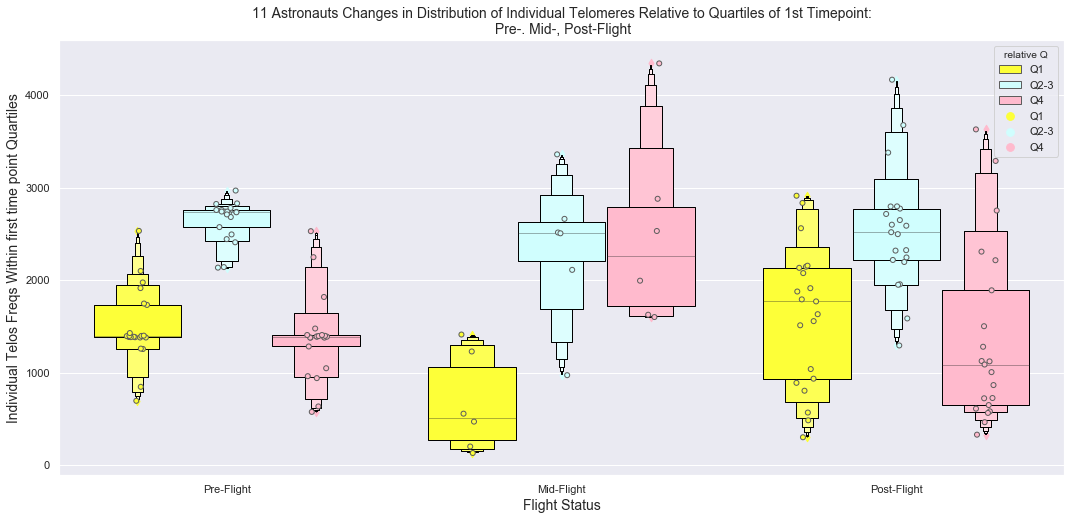

In [581]:
fig = plt.figure(figsize=(18,8))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

ax = sns.boxenplot(x='flight status', y='Q freq counts', hue='relative Q', data=distal_melted_quartiles_astro_df, palette=palette,
             linewidth=2, saturation=5, color="black")
ax = sns.stripplot(x='flight status', y='Q freq counts', hue='relative Q', data=distal_melted_quartiles_astro_df, palette=palette,
             linewidth=1, color="black", dodge=True)

ax=fig.gca()
ax.set_title('11 Astronauts Changes in Distribution of Individual Telomeres Relative to Quartiles of 1st Timepoint:\n Pre-. Mid-, Post-Flight', fontsize=14)
ax.set_xlabel('Flight Status', fontsize=14)
ax.set_ylabel('Individual Telos Freqs Within first time point Quartiles', fontsize=14)

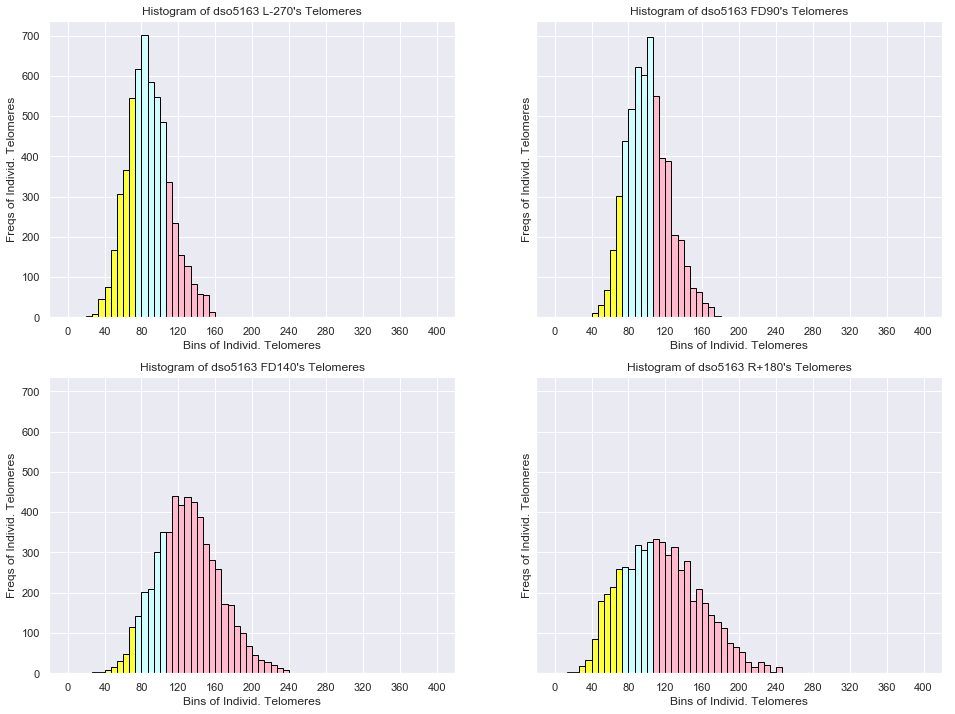

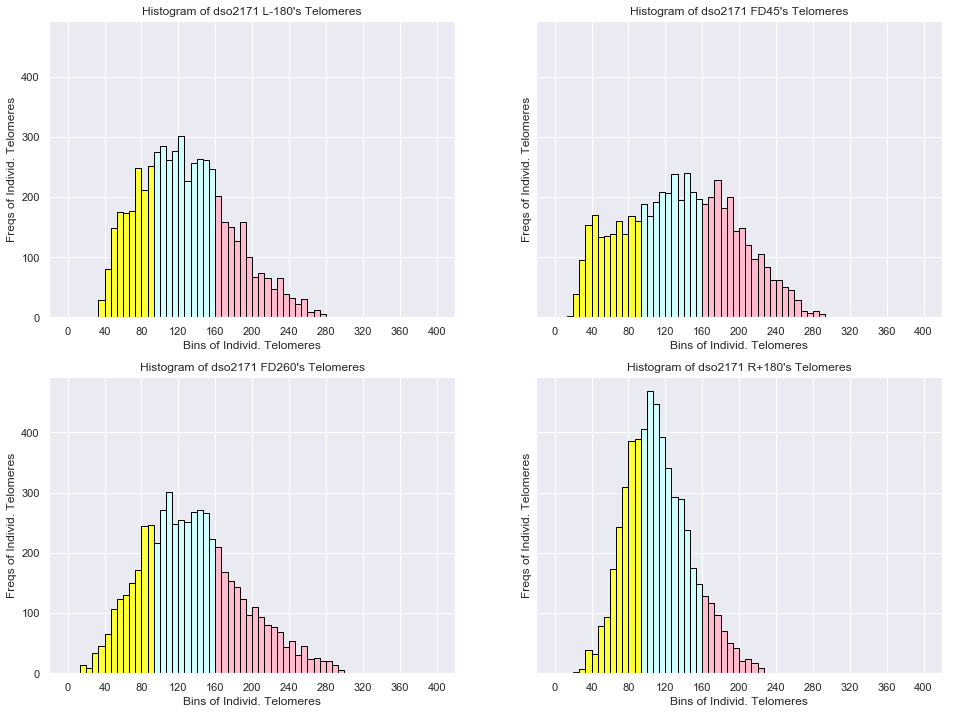

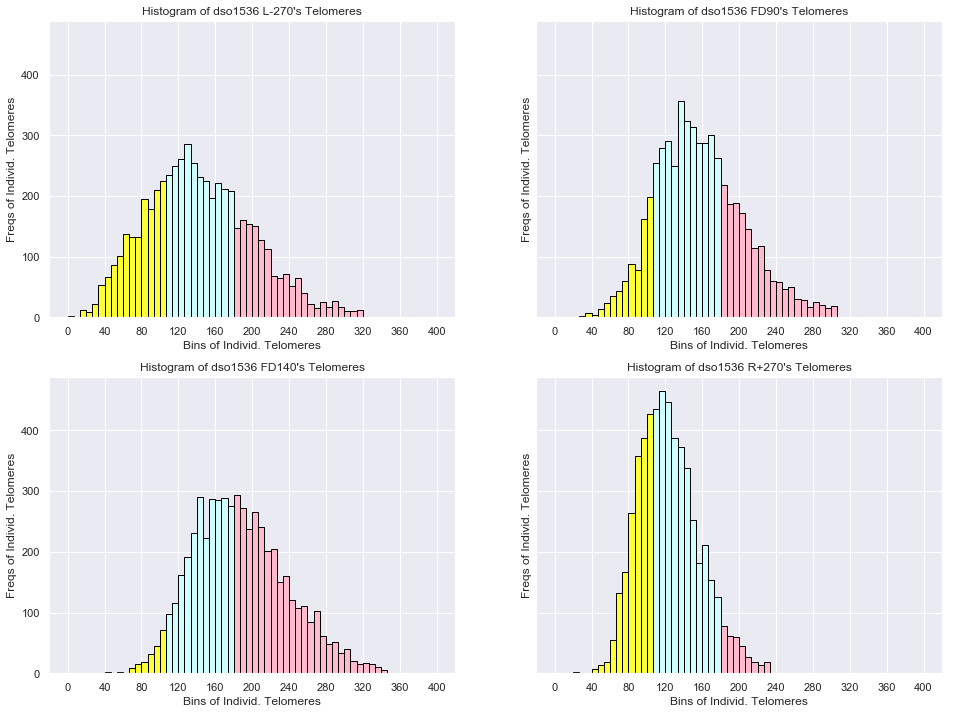

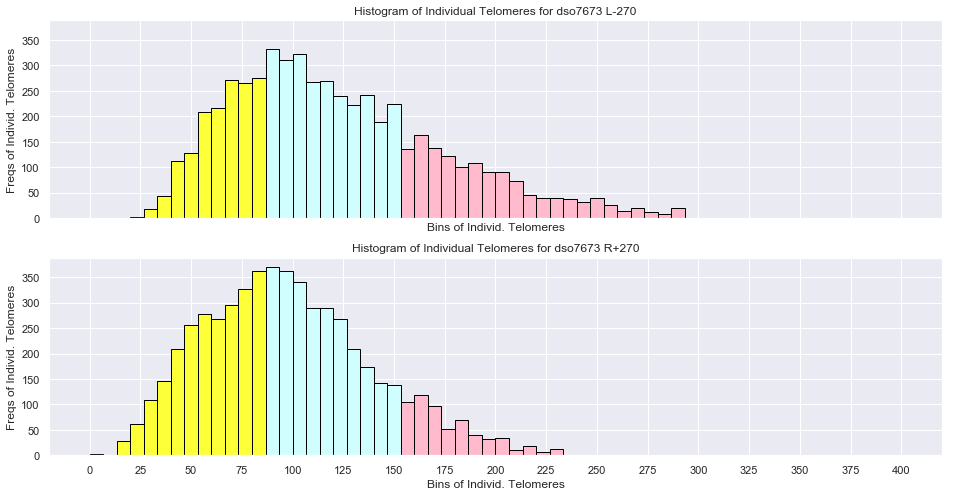

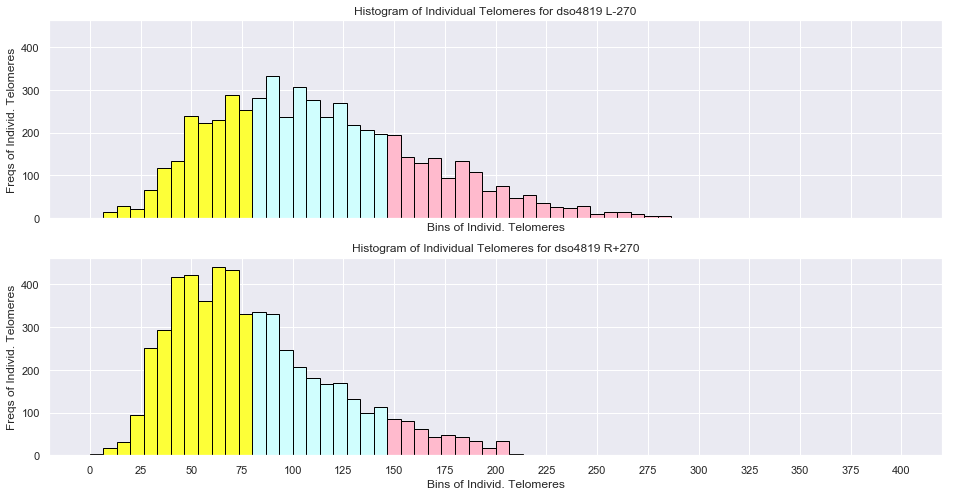

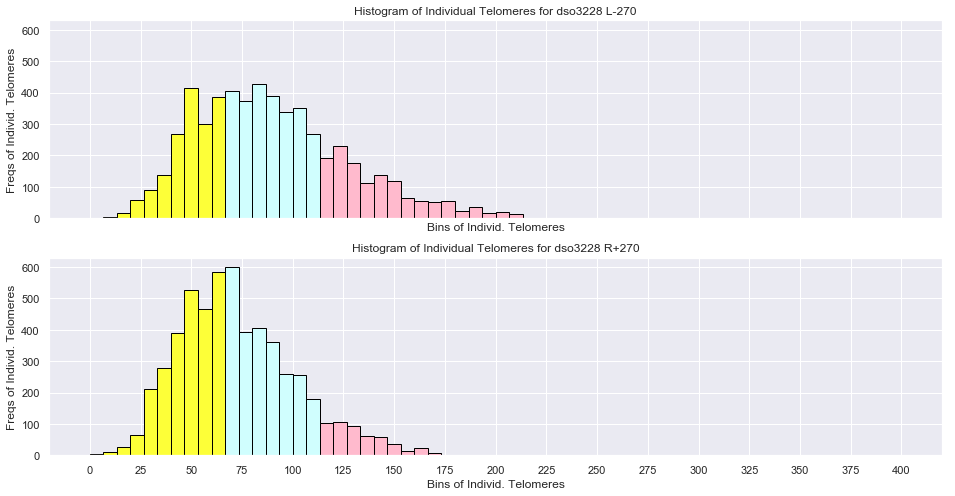

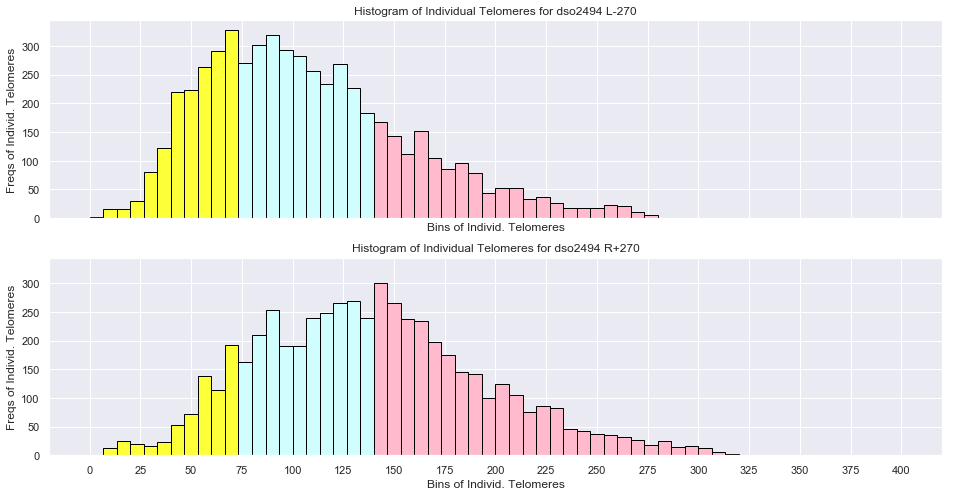

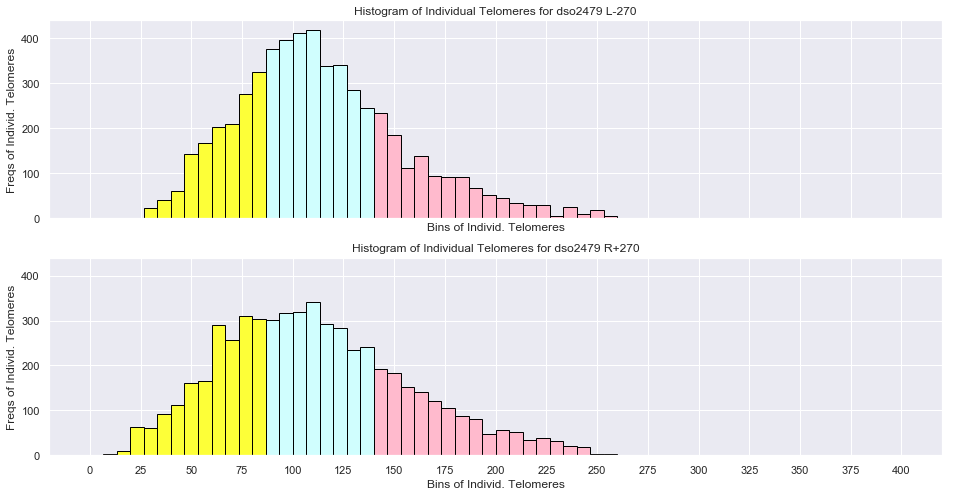

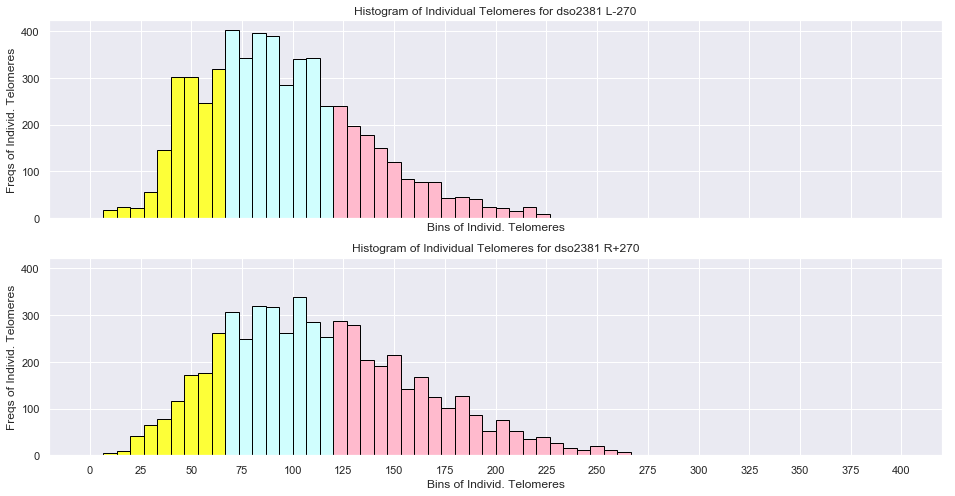

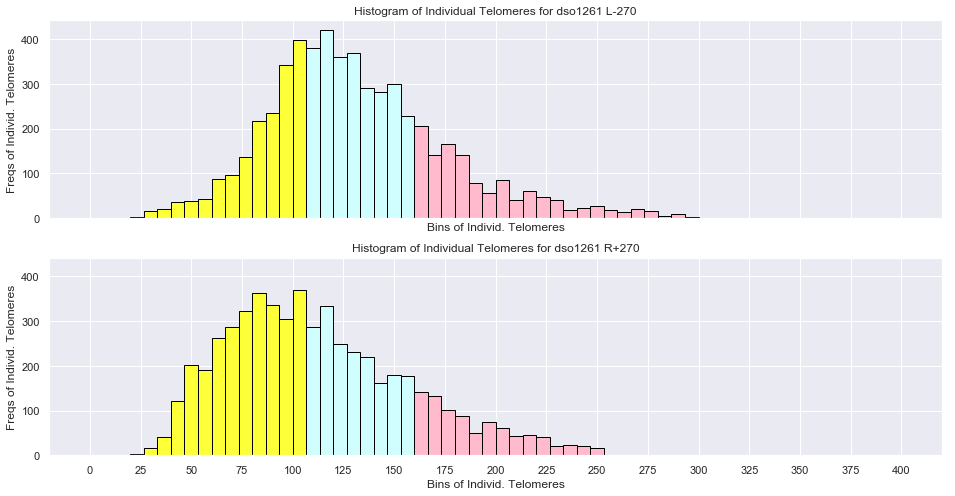

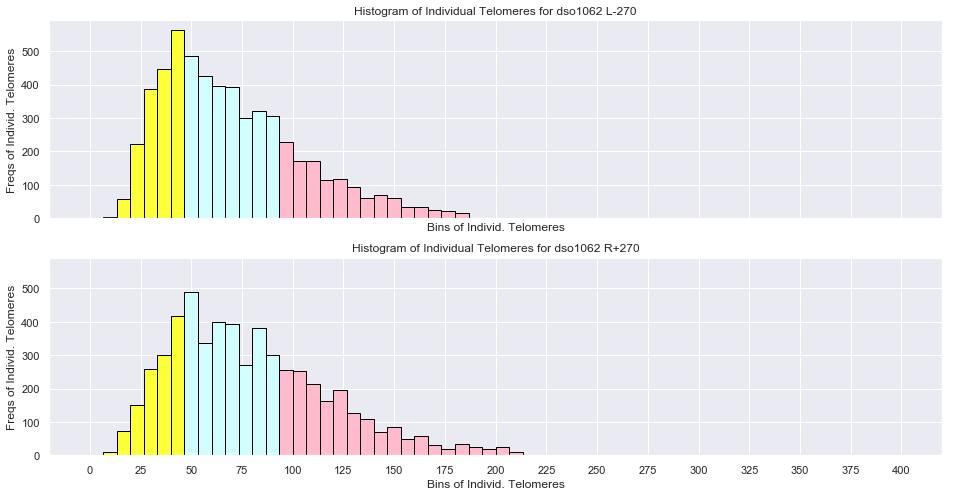

In [582]:
telo_ma.make_histograms_colored_by_quartile_for_astronauts(exploded_telos_astro_df)

### Reading in astronaut urine biochem data

In [65]:
melt_urine_biochem_data = pd.read_csv('../excel data/melt_urine_biochem_data.csv')
melt_urine_biochem_data.head(4)

,biochemistry,sample type,timepoint,measurement,flight status,measurement trim
0,"8-OHdG, Urine ug/gCr",urine,Pre,2.6 ± 1,Pre-Flight,2.60
1,"Copper, Urine umol/day",urine,Pre,0.28 ± 0.17,Pre-Flight,0.28
2,PGF2-alpha ng/mg Cr,urine,Pre,1.84 ± 1.2,Pre-Flight,1.84
3,"Selenium, Urine umol/day",urine,Pre,1.02 ± 0.39,Pre-Flight,1.02


### Merging flight status / biochemistry test data

In [240]:
# grouping urine biochem data by flight status & biochemistry test & taking mean of timepoints

group_melt_urine_biochem_data = melt_urine_biochem_data.groupby(['flight status', 'biochemistry']).agg('mean').reset_index()

In [241]:
# grouping astronaut data by flight status and taking mean

trim_astro_df = astro_df.drop(['astro number', 'telo data', 'Q1', 'Q2-3', 'Q4'], axis=1)
group_astros_telos = trim_astro_df.groupby('flight status').agg('mean').reset_index()

In [242]:
merge_grouped_urine_telos = group_melt_urine_biochem_data.merge(group_astros_telos, on='flight status')

In [243]:
sorter = ['Pre-Flight', 'Mid-Flight', 'Post-Flight']

merge_grouped_urine_telos['flight status'] = merge_grouped_urine_telos['flight status'].astype('category')
merge_grouped_urine_telos['flight status'].cat.set_categories(sorter, inplace=True)
merge_grouped_urine_telos = merge_grouped_urine_telos.sort_values('flight status').reset_index(drop=True)

In [260]:
merge_grouped_urine_telos.head()

,flight status,biochemistry,measurement trim,telo means
0,Pre-Flight,"8-OHdG, Urine ug/gCr",2.60,107.288598
1,Pre-Flight,"Copper, Urine umol/day",0.28,107.288598
2,Pre-Flight,PGF2-alpha ng/mg Cr,1.84,107.288598
3,Pre-Flight,"Selenium, Urine umol/day",1.02,107.288598
4,Mid-Flight,"8-OHdG, Urine ug/gCr",3.04,140.872973


In [78]:
alpha = merge_grouped_urine_telos.groupby('biochemistry')

In [144]:
for group in list(merge_grouped_urine_telos['biochemistry'].unique()):
    print(group)
    print(alpha.get_group(group).corr()['telo means'][0], '\n')

8-OHdG, Urine ug/gCr
0.8763225786238364 

Copper, Urine umol/day
-0.8553730109572085 

PGF2-alpha ng/mg Cr
0.9970805104031575 

Selenium, Urine umol/day
0.9664254217154524 



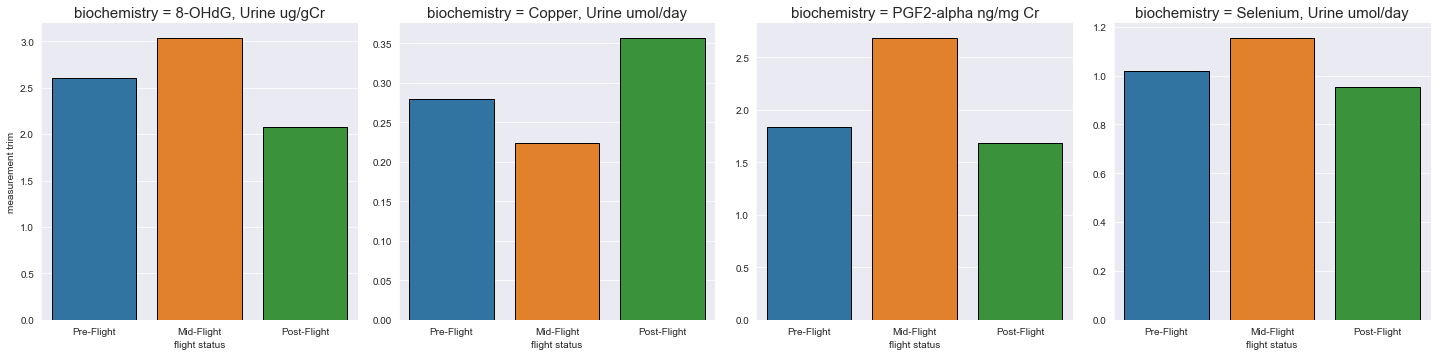

In [208]:
ax = sns.catplot(x='flight status', y='measurement trim', data=merge_grouped_urine_telos,
           col='biochemistry', col_wrap=6, kind='bar', sharey=False,)

ax.set_titles(size=15)

In [146]:
melt_blood_biochem_data = pd.read_csv('../excel data/melt_blood_biochem_data.csv')
melt_blood_biochem_data.head(4)

,biochemistry,sample type,timepoint,measurement,flight status,measurement trim
0,CCL2/MCP-1 pg/ml,blood,Pre,83 ± 17,Pre-Flight,83.0
1,CCL3/MIP-1a pg/ml,blood,Pre,438 ± 194,Pre-Flight,438.0
2,CCL4/MIP1B pg/ml,blood,Pre,54 ± 17,Pre-Flight,54.0
3,CCL5/RANTES pg/ml,blood,Pre,6902 ± 4393,Pre-Flight,6902.0


In [147]:
group_melt_blood_biochem_data = melt_blood_biochem_data.groupby(['flight status', 'biochemistry']).agg('mean').reset_index()

In [148]:
trim_astro_df = astro_df.drop(['astro number', 'telo data', 'Q1', 'Q2-3', 'Q4'], axis=1)
group_astros_telos = trim_astro_df.groupby('flight status').agg('mean').reset_index()

In [149]:
merge_grouped_blood_telos = group_melt_blood_biochem_data.merge(group_astros_telos, on='flight status')

In [150]:
sorter = ['Pre-Flight', 'Mid-Flight', 'Post-Flight']

merge_grouped_blood_telos['flight status'] = merge_grouped_blood_telos['flight status'].astype('category')
merge_grouped_blood_telos['flight status'].cat.set_categories(sorter, inplace=True)
merge_grouped_blood_telos = merge_grouped_blood_telos.sort_values('flight status').reset_index(drop=True)

In [151]:
merge_grouped_blood_telos.head()

,flight status,biochemistry,measurement trim,telo means
0,Pre-Flight,hs CRP mg/L,1.15,107.288598
1,Pre-Flight,"Glutathione, Total umol/L",1266.00,107.288598
2,Pre-Flight,"Glutathione, Oxidized umol/L",225.00,107.288598
3,Pre-Flight,GPX U/g Hgb,45.00,107.288598
4,Pre-Flight,GM-CSF pg/ml,21.00,107.288598


In [152]:
beta_groups = merge_grouped_blood_telos.groupby('biochemistry')

In [265]:
# df.corr?

In [270]:
high_corr_tests = {}

for group in list(merge_grouped_blood_telos['biochemistry'].unique()):
    
    # number of nas in dataframe
    if beta_groups.get_group(group).isna().sum().sum() == 0:
#         display(beta_groups.get_group(group))

        if abs(beta_groups.get_group(group).corr()['telo means'][0]) > 0.7:
#             high_corr_tests[group] = beta_groups.get_group(group).corr()['telo means'][0]
            print(f"{group} CORRELATION WITH TELO MEANS IS: {beta_groups.get_group(group).corr()['telo means'][0]}")

hs CRP mg/L CORRELATION WITH TELO MEANS IS: -0.8314515239806588
GM-CSF pg/ml CORRELATION WITH TELO MEANS IS: 0.9677245094082189
G-CSF pg/ml CORRELATION WITH TELO MEANS IS: 0.9814018280843974
Folate, Serum nmol/L CORRELATION WITH TELO MEANS IS: -0.8476172352654097
Ferritin ng/mL CORRELATION WITH TELO MEANS IS: 0.937869309937645
FGF Basic Immune Lab pg/ml CORRELATION WITH TELO MEANS IS: 0.9816419150546664
CXCL5/ENA-78 pg/ml CORRELATION WITH TELO MEANS IS: 0.996129023064366
CCL5/RANTES pg/ml CORRELATION WITH TELO MEANS IS: 0.99223261750913
CCL4/MIP1B pg/ml CORRELATION WITH TELO MEANS IS: 0.9976037975218974
CCL3/MIP-1a pg/ml CORRELATION WITH TELO MEANS IS: 0.9650783700830434
Hepcidin-25 Bioactive ng/mL CORRELATION WITH TELO MEANS IS: 0.9899235430522081
IL-1 beta Immune Lab pg/ml CORRELATION WITH TELO MEANS IS: 0.9973163078647262
IL-17 pg/ml CORRELATION WITH TELO MEANS IS: 0.9494377050985754
Vitamin B12 pmol/L CORRELATION WITH TELO MEANS IS: 0.9723314416465609
VEGF-1 Immune Lab pg/ml CORREL

In [185]:
del high_corr_tests['Selenium, Serum umol/L']

In [186]:
high_corr_df = pd.DataFrame()

for test in high_corr_tests:
    df = merge_grouped_blood_telos[merge_grouped_blood_telos['biochemistry'] == test]
    high_corr_df = pd.concat([df, high_corr_df], axis=0)

In [214]:
high_corr_df.head(4)

,flight status,biochemistry,measurement trim,telo means
34,Pre-Flight,IL-1a pg/ml,27.0,107.288598
40,Mid-Flight,IL-1a pg/ml,42.4,140.872973
93,Post-Flight,IL-1a pg/ml,23.5,104.379082
33,Pre-Flight,IL-1ra pg/ml,473.0,107.288598


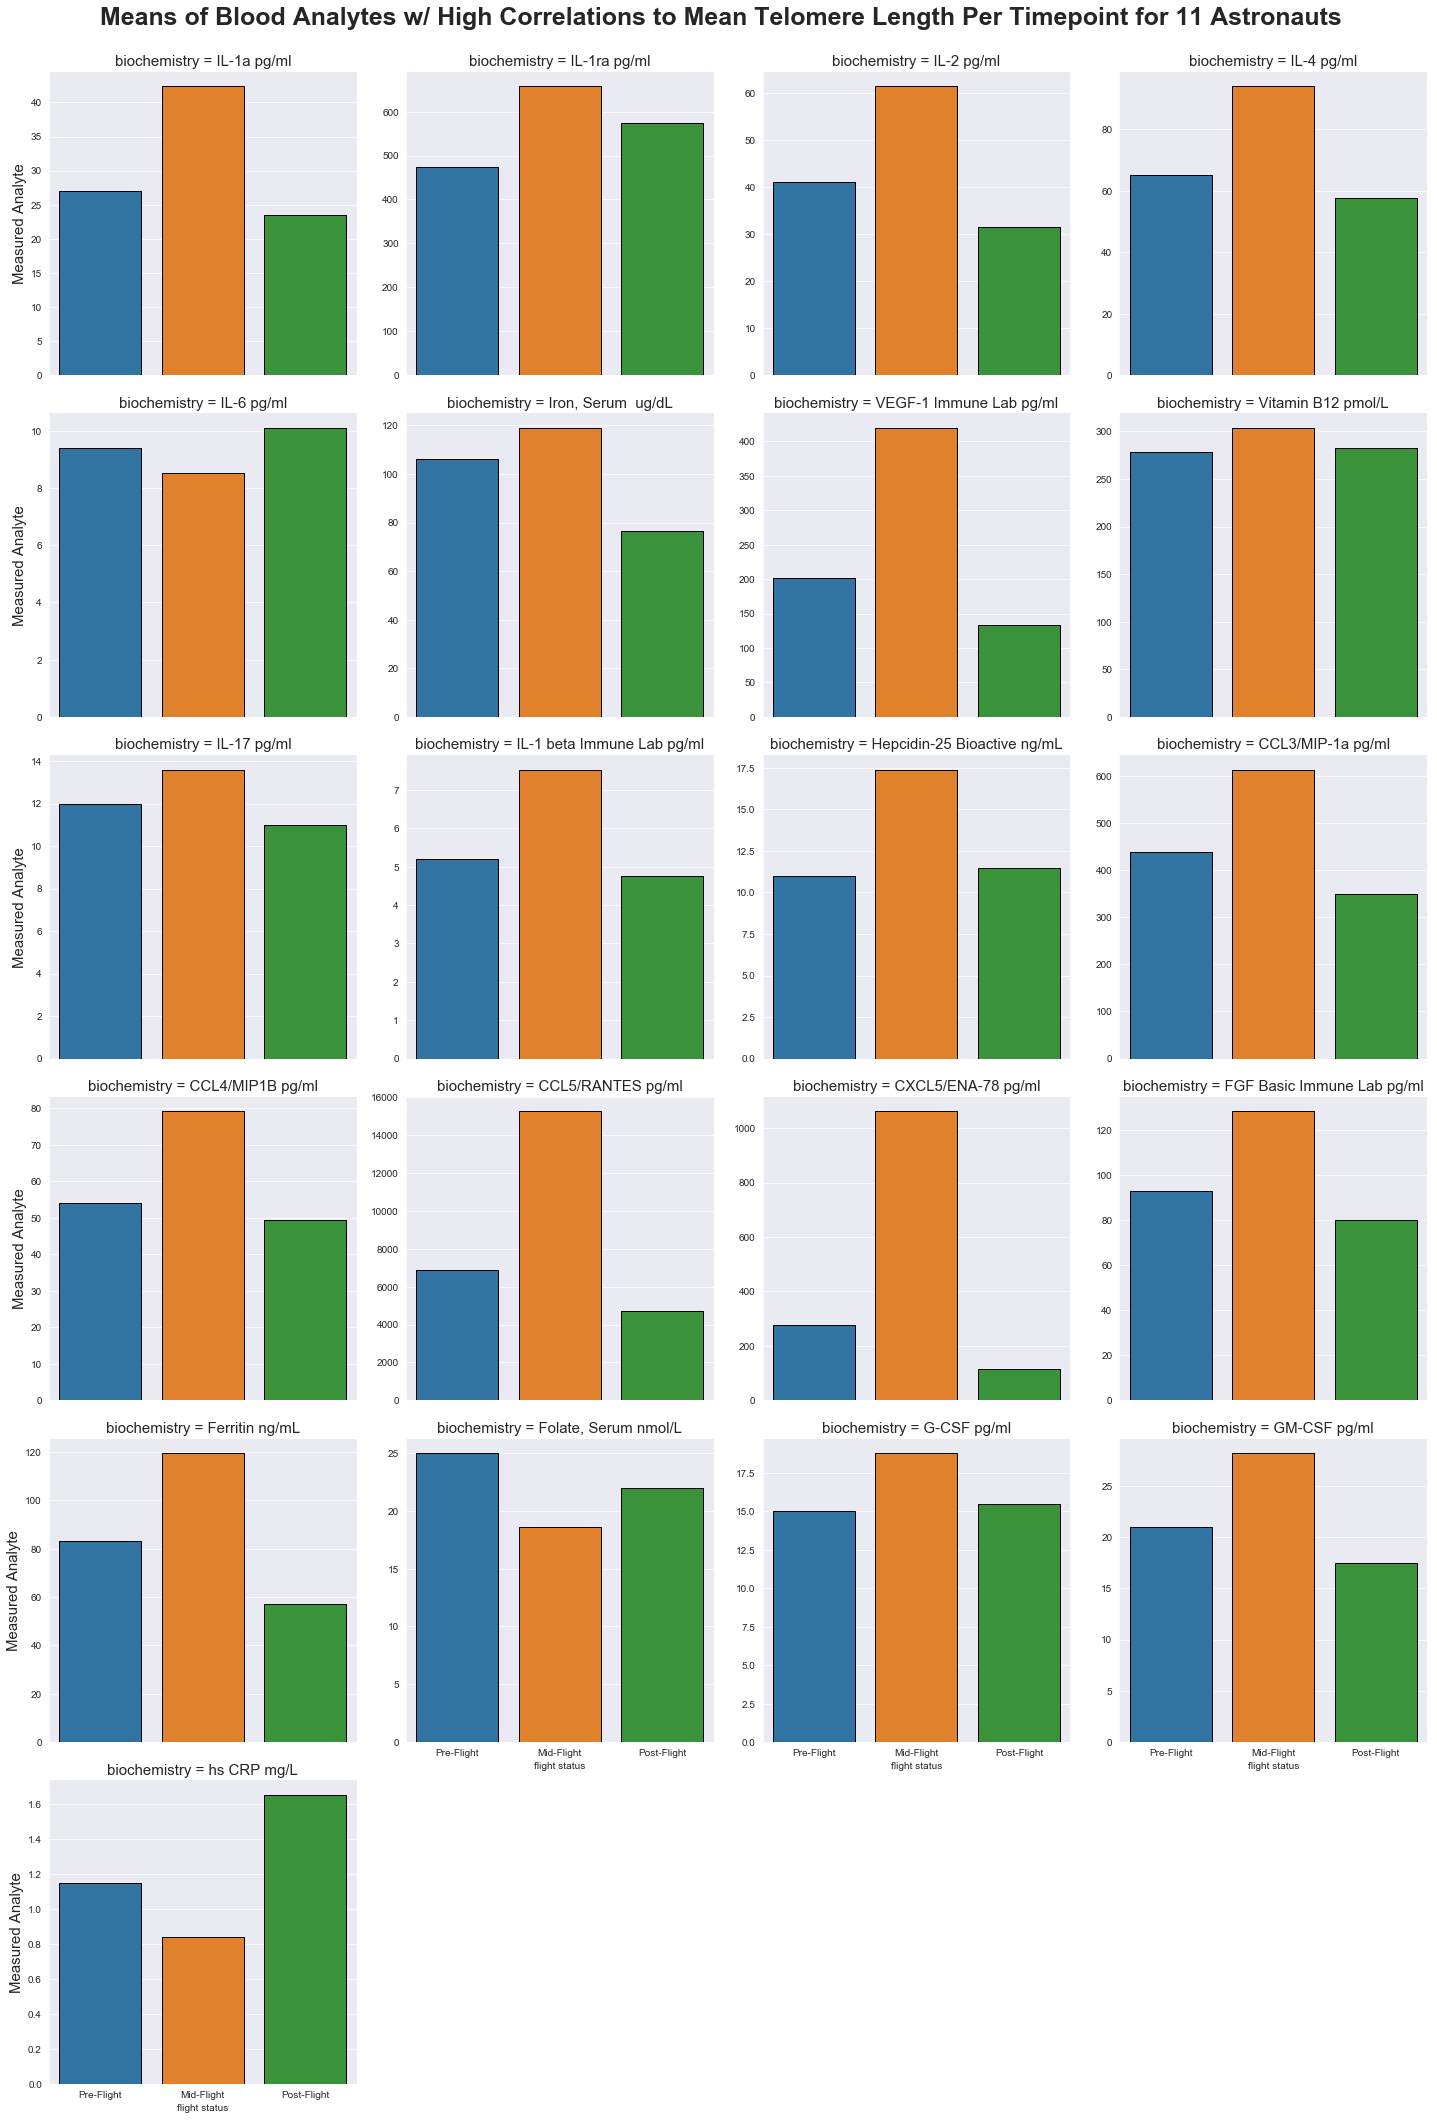

In [207]:
ax = sns.catplot(x='flight status', y='measurement trim', data=high_corr_df,
           **{'ci':'sd'}, col='biochemistry', col_wrap=4, kind='bar', sharey=False,)


fig = ax.fig 
    
fig.suptitle(f'Means of Blood Analytes w/ High Correlations to Mean Telomere Length Per Timepoint for 11 Astronauts', fontsize=25, weight='bold')
plt.subplots_adjust(top=0.95)
ax.set_titles(size=15)
ax.set_ylabels('Measured Analyte', size=15)

plt.savefig('./graph data/high_correlation_blood_markers.png')